In [1]:
import pandas as pd
import numpy as np
import rebound
import matplotlib.pyplot as plt
from matplotlib import colors
from rebound.interruptible_pool import InterruptiblePool
import scipy.optimize as opt
import cmath
from scipy.optimize import minimize_scalar
plt.style.use('paper.mplstyle')

In [2]:
%run helper_function.ipynb

In [3]:
# Eq.(14) in Hadden (2018) is a better approximation at low ecc
def calcBoundary(mass,te12):
    func = lambda a : np.abs(0.72*np.exp(-1.4*mass**(1/3)*(a/(a-1))**(4/3)) - te12)
    res = minimize_scalar(func,bounds=[1.001,3])
    return 1/res.x   # alpha12 at the stability boundary

In [4]:
# see thesis Appendix D
def breathingON(mass, alpha, A1_off):
    chi12, chi23 = calcChi(mass,alpha)
    if chi12 > 1/2:
        phi = np.arccos((1-2*chi12)/(2*chi12))
    else:
        phi = np.arccos(-(1-2*chi12)/(2*chi12))
    A2_on = A1_off/np.sqrt(chi12)
    A1_on = np.sqrt(chi12)*A1_off
    return A1_on, A2_on, phi

In [5]:
# calculate the closest j-k:j resonance
def closest(num, arr):
    index = 0
    curr = arr[0]
    for i, value in enumerate(arr):
        if abs(num-value) < abs(num-curr):
            curr = value
            index = i
    return index

def calcParam(alpha12):
    P_ratio = alpha12**(3/2)
    true_ratio = [(j-k)/j for j in np.arange(4,15) for k in np.arange(1,3)]
    ref = [[j,k] for j in np.arange(4,15) for k in np.arange(1,3)]
    index = closest(P_ratio, true_ratio)
    return ref[index]

In [6]:
MASS = 1e-5, 1e-15, 1e-5
timescale = 1e5
f = 0.1  # percentage of orbit-crossing value

In [7]:
print(rf"The 2-planet boundary is at $\alpha_{12}$ = {calcBoundary(MASS[0],f)}")

The 2-planet boundary is at $\alpha_12$ = 0.9565413518260082


In [8]:
# 2-planet
def sim2Planet(alpha12):
    mu1, mu2 = MASS[0], MASS[1]
    P1, P2 = 1, alpha12**(-3/2)
    ecc1, ecc2 = 0, f*(1-alpha12)/alpha12
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1)
    sim.add(m=mu2, P=P2, e=f*(1-alpha12)/alpha12, pomega=0, l=0)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = sim.particles[1].P/12
    sim.collision = "direct"
    
    sim.init_megno()
    Nout = 2000
    times = np.linspace(0,timescale, Nout)
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
        except rebound.Collision:
            return 4000
    return sim.calculate_megno()

In [9]:
# 3-planet
def simNoBreathing(alpha):
    alpha12, alpha23 = alpha
    ecc_nb, pomega_nb = AtoE(alpha, MASS, (f*(1-alpha12)/alpha12, 0, 0), (0, 0, 0))
    j, k = calcParam(alpha12)[0], calcParam(alpha12)[1]
    Lambda = 1, (k*(pomega_nb[1]-pomega_nb[0]) + np.pi + (j-k))/j, 0   # start the system at phi=0, see Rath at al. (2022)
    sim = make_sim(alpha, MASS, ecc_nb, pomega_nb, Lambda)
    
    sim.init_megno()
    Nout = 2000
    times = np.linspace(0,timescale, Nout)
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
        except rebound.Collision:
            return 4000
    return sim.calculate_megno()

In [10]:
def simWithBreathing(alpha):
    alpha12, alpha23 = alpha
    amp1_wb, amp2_wb, phi = breathingON(MASS, alpha,f*(1-alpha12)/alpha12)
    ecc_wb, pomega_wb = AtoE(alpha, MASS, (amp1_wb, amp2_wb, 0), (0, phi, 0))
    j, k = calcParam(alpha12)[0], calcParam(alpha12)[1]
    Lambda = 1, (k*(pomega_wb[1]-pomega_wb[0]) + np.pi + (j-k))/j, 0
    sim = make_sim(alpha, MASS, ecc_wb, pomega_wb, Lambda)
        
    sim.init_megno()
    Nout = 2000
    times = np.linspace(0,timescale, Nout)
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
        except rebound.Collision:
            return 4000
    return sim.calculate_megno()

In [11]:
Ngrid_x = 500
Ngrid_y = 1

alpha12 = np.linspace(0.7,0.9,Ngrid_x)
alpha23 = np.linspace(0.5,0.5,Ngrid_y)
parameters = [[x,y] for x in alpha12 for y in alpha23]

pool = InterruptiblePool()
megno_2p = pool.map(sim2Planet,alpha12)
megno_3p = pool.map(simNoBreathing,parameters)

In [12]:
# rescale the elements in MEGNO to 0 if regular and 1 if chaotic
def rescale(data):
    data_rescaled = np.zeros(len(data))
    for i, x in enumerate(data):
        if x<1.8 or x>2.2:
            data_rescaled[i] = 1
        else:
            data_rescaled[i] = 0
    return data_rescaled

# average smoothing
def process(data,stepsize):
    data_smoothed = np.zeros(len(data))
    for i in range(len(data)):
        if i < stepsize:
            avg = np.mean(data[0:i+stepsize+1])
        elif i > len(data)-stepsize-1:
            avg = np.mean(data[i-stepsize:])
        else:
            avg = np.mean(data[i-stepsize:i+stepsize+1])
        data_smoothed[i] = avg
    return data_smoothed

def smooth(data,stepsize,repeat):
    result = data[:]
    for i in range(repeat):
        step = round(stepsize / 2**i)
        result = process(result,step)
    return result

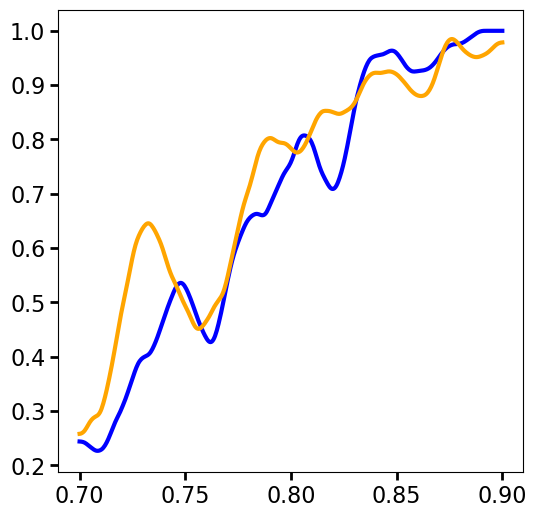

In [13]:
data_2p = rescale(megno_2p)
density2p = smooth(data_2p, 20, 5)

data_3p = rescale(megno_3p)
density3p = smooth(data_3p, 20, 5)

fig, ax = plt.subplots()
ax.plot(alpha12, density2p, color='blue')
ax.plot(alpha12, density3p, color='orange')